In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [4]:
### Choosing Device

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [7]:
### Import Dataset
w, b = 0.7, 0.3

X = torch.arange(start = 0, end = 1, step = 0.02).unsqueeze(dim = 1)
y = w * X + b

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

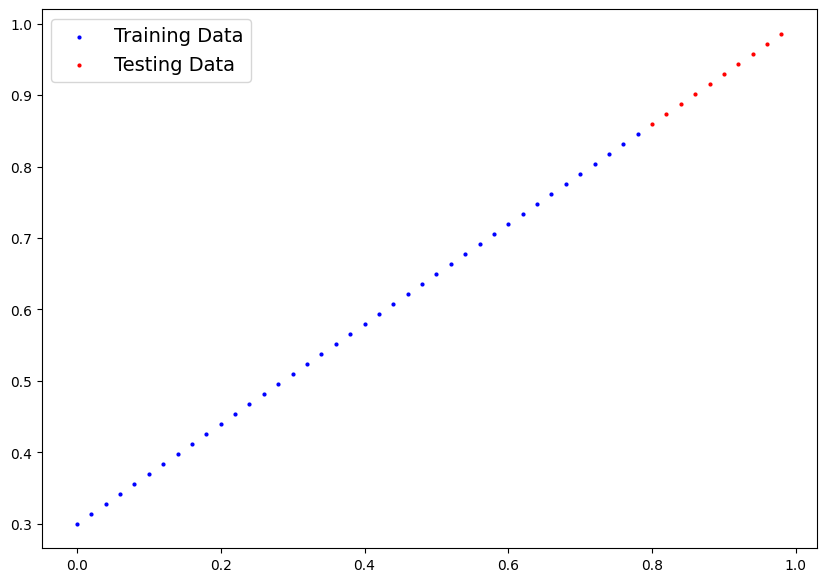

In [9]:
### Plotting
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    plt.figure(figsize = (10, 7))

    # Training Data: Blue
    plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training Data")

    # Testing Data: Red
    plt.scatter(test_data, test_labels, c = "r", s = 4, label = "Testing Data")

    if predictions is not None:
        # Predictions; Green
        plt.scatter(test_data, predictions, c = "g", s = 4, label = "Prediction Data")

    plt.legend(prop = {"size": 14})

plot_predictions()

In [11]:
### Building Model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linearLayer = nn.Linear(in_features = 1, out_features = 1)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.linearLayer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linearLayer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linearLayer.weight', tensor([[0.7645]])),
              ('linearLayer.bias', tensor([0.8300]))]))

In [14]:
### Put the model on GPU

# Check
print(f"Current Device: {next(model_1.parameters()).device}")

model_1.to(device)
print(f"Current Device: {next(model_1.parameters()).device}")

Current Device: cpu
Current Device: cuda:0


In [15]:
### Training and Testing

loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

torch.manual_seed(42)

epochs = 1000

# Put the data on GPU (Without implementing, the program can get cross-device errors)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training

    # 1. Put the model on training mode
    model_1.train()

    # 2. Forward-pass
    y_pred = model_1(X_train)

    # 3. Calculate loss
    loss = loss_function(y_pred, y_train)

    # 4. Clear accumulated grad
    optimizer.zero_grad()

    # 5. Calculate gradients for backward pass
    loss.backward()

    # 6. Updates parameters
    optimizer.step()

    ### Testing

    # 1. Put the model in evaluation mode
    model_1.eval()

    # 2. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 3. Calculate the loss
        test_loss = loss_function(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [17]:
# Find our model's learned parameters
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {w}, bias: {b}")

The model learned the following values for weights and bias:
OrderedDict([('linearLayer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linearLayer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


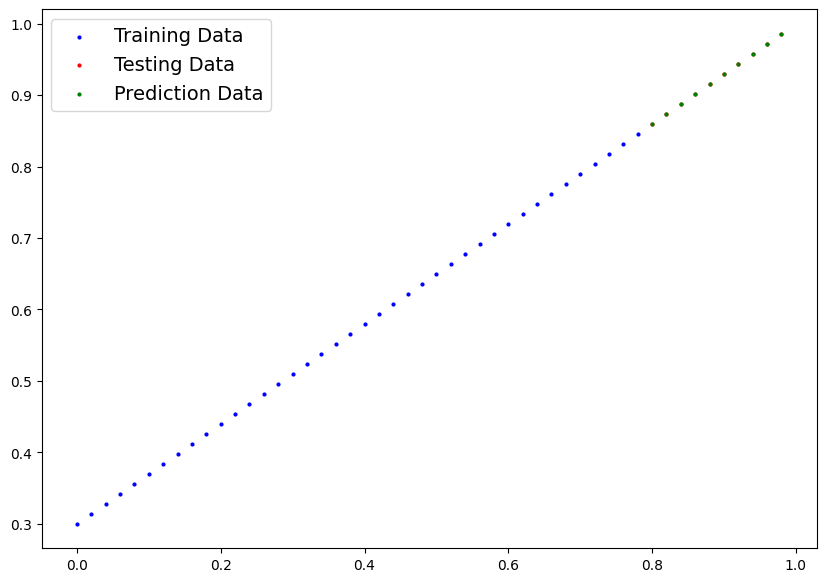

In [20]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

# Put the data on cpu before plotting
plot_predictions(predictions = y_preds.cpu())

In [21]:
### Saving Model

from pathlib import Path

# 1. Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Save Path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [23]:
### Loading Model

loaded_model_1 = LinearRegressionModel()

loaded_model_1.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Put the model on GPU
loaded_model_1.to(device)
print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModel(
  (linearLayer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


<ipython-input-23-39758db36a62>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


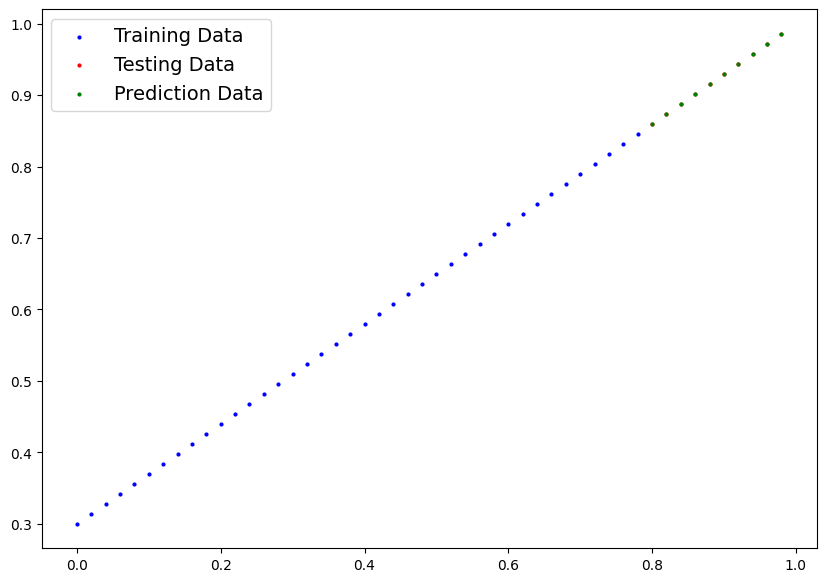

In [25]:
### Making Predictions after Loading

loaded_model_1.eval()

with torch.inference_mode():
    loaded_preds = loaded_model_1(X_test)

plot_predictions(predictions = loaded_preds.cpu())